# Benchmark of existing approaches for detecting machine-generated text

## Contents 
1. [GLTR](#GLRT)
    1. [Install dependencies](#Install-dependencies)
    1. [GLTR Code](#GLTR-Code)
    

## GLTR

_Sebastian Gehrmann, Hendrik Strobelt, and Alexander M. Rush. 2019. "Gltr: Statistical detection and visualization of generated text"._

This is a zero-shot approach (no fine tuning of LM). The original code provides a webserver, which receives a text as input and returns a set of statistics, which are then rendered client-side. 

### Install dependencies
Dependencies from: [https://github.com/HendrikStrobelt/detecting-fake-text/blob/master/requirements.txt](detecting-fake-text/requirements.txt).

In [1]:
# pytorch-pretrained-bert>=0.6.1
!pip install transformers
!pip install torch
!pip install numpy
!pip install connexion[swagger-ui]
!pip install flask
!pip install PyYaml
!pip install flask_cors

zsh:1: no matches found: connexion[swagger-ui]


### GLTR Code
Source code: [https://github.com/HendrikStrobelt/detecting-fake-text](https://github.com/HendrikStrobelt/detecting-fake-text)

Logic extracted form `backend/api.py`

In [2]:
import numpy as np
import torch
import time

from transformers import (GPT2LMHeadModel, GPT2Tokenizer,
                          BertTokenizer, BertForMaskedLM)

In [3]:
def top_k_logits(logits, k):
    if k == 0:
        return logits
    values, _ = torch.topk(logits, k)
    min_values = values[:, -1]
    return torch.where(logits < min_values,
                       torch.ones_like(logits, dtype=logits.dtype) * -1e10,
                       logits)


In [4]:
class GPT2BasedGLTR():
    def __init__(self, model_name_or_path="gpt2"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.enc = GPT2Tokenizer.from_pretrained(model_name_or_path)
        self.model = GPT2LMHeadModel.from_pretrained(model_name_or_path)
        self.model.to(self.device)
        self.model.eval()
        self.start_token = self.enc(self.enc.bos_token, return_tensors='pt').data['input_ids'][0]
        print("Loaded GPT-2 model!")    

    def check_probabilities(self, in_text, topk=40):
        # Process input
        token_ids = self.enc(in_text, return_tensors='pt').data['input_ids'][0]
        token_ids = torch.concat([self.start_token, token_ids])
        # Forward through the model
        output = self.model(token_ids.to(self.device))
        all_logits = output.logits[:-1].detach().squeeze()
        # construct target and pred
        # yhat = torch.softmax(logits[0, :-1], dim=-1)
        all_probs = torch.softmax(all_logits, dim=1)

        y = token_ids[1:]
        # Sort the predictions for each timestep
        sorted_preds = torch.argsort(all_probs, dim=1, descending=True).cpu()
        # [(pos, prob), ...]
        real_topk_pos = list(
            [int(np.where(sorted_preds[i] == y[i].item())[0][0])
             for i in range(y.shape[0])])
        real_topk_probs = all_probs[np.arange(
            0, y.shape[0], 1), y].data.cpu().numpy().tolist()
        real_topk_probs = list(map(lambda x: round(x, 5), real_topk_probs))

        real_topk = list(zip(real_topk_pos, real_topk_probs))
        # [str, str, ...]
        bpe_strings = self.enc.convert_ids_to_tokens(token_ids[:])

        bpe_strings = [self.postprocess(s) for s in bpe_strings]

        topk_prob_values, topk_prob_inds = torch.topk(all_probs, k=topk, dim=1)

        pred_topk = [list(zip(self.enc.convert_ids_to_tokens(topk_prob_inds[i]),
                              topk_prob_values[i].data.cpu().numpy().tolist()
                              )) for i in range(y.shape[0])]
        pred_topk = [[(self.postprocess(t[0]), t[1]) for t in pred] for pred in pred_topk]

        # pred_topk = []
        payload = {'bpe_strings': bpe_strings,
                   'real_topk': real_topk,
                   'pred_topk': pred_topk}
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return payload

    def sample_unconditional(self, length=100, topk=5, temperature=1.0):
        '''
        Sample `length` words from the model.
        Code strongly inspired by
        https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_gpt2.py

        '''
        context = torch.full((1, 1),
                             # ORIGINAL: self.enc.encoder[self.start_token,
                             int(self.start_token[0]), # FIX
                             device=self.device,
                             dtype=torch.long)
        prev = context
        output = context
        past = None
        # Forward through the model
        with torch.no_grad():
            for i in range(length):
                # ORIGINAL: logits, past = self.model(prev, past_key_values=past)
                logits = self.model(prev, past_key_values=past).logits # FIX
                logits = logits[:, -1, :] / temperature
                # Filter predictions to topk and softmax
                probs = torch.softmax(top_k_logits(logits, k=topk),
                                      dim=-1)
                # Sample
                prev = torch.multinomial(probs, num_samples=1)
                # Construct output
                output = torch.cat((output, prev), dim=1)

        output_text = self.enc.decode(output[0].tolist())
        return output_text

    def postprocess(self, token):
        with_space = False
        with_break = False
        if token.startswith('Ġ'):
            with_space = True
            token = token[1:]
            # print(token)
        elif token.startswith('â'):
            token = ' '
        elif token.startswith('Ċ'):
            token = ' '
            with_break = True

        token = '-' if token.startswith('â') else token
        token = '“' if token.startswith('ľ') else token
        token = '”' if token.startswith('Ŀ') else token
        token = "'" if token.startswith('Ļ') else token

        if with_space:
            token = '\u0120' + token
        if with_break:
            token = '\u010A' + token

        return token

In [5]:
class BERTBasedGLTR():
    def __init__(self, model_name_or_path="bert-base-cased"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.tokenizer = BertTokenizer.from_pretrained(
            model_name_or_path,
            do_lower_case=False)
        self.model = BertForMaskedLM.from_pretrained(
            model_name_or_path)
        self.model.to(self.device)
        self.model.eval()
        # BERT-specific symbols
        self.mask_tok = self.tokenizer.convert_tokens_to_ids(["[MASK]"])[0]
        self.pad = self.tokenizer.convert_tokens_to_ids(["[PAD]"])[0]
        print("Loaded BERT model!")

    def check_probabilities(self, in_text, topk=40, max_context=20,
                            batch_size=20):
        '''
        Same behavior as GPT-2
        Extra param: max_context controls how many words should be
        fed in left and right
        Speeds up inference since BERT requires prediction word by word
        '''
        in_text = "[CLS] " + in_text + " [SEP]"
        tokenized_text = self.tokenizer.tokenize(in_text)
        # Construct target
        y_toks = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        # Only use sentence A embedding here since we have non-separable seq's
        segments_ids = [0] * len(y_toks)
        y = torch.tensor([y_toks]).to(self.device)
        segments_tensor = torch.tensor([segments_ids]).to(self.device)

        # TODO batching...
        # Create batches of (x,y)
        input_batches = []
        target_batches = []
        for min_ix in range(0, len(y_toks), batch_size):
            max_ix = min(min_ix + batch_size, len(y_toks) - 1)
            cur_input_batch = []
            cur_target_batch = []
            # Construct each batch
            for running_ix in range(max_ix - min_ix):
                tokens_tensor = y.clone()
                mask_index = min_ix + running_ix
                tokens_tensor[0, mask_index + 1] = self.mask_tok

                # Reduce computational complexity by subsetting
                min_index = max(0, mask_index - max_context)
                max_index = min(tokens_tensor.shape[1] - 1,
                                mask_index + max_context + 1)

                tokens_tensor = tokens_tensor[:, min_index:max_index]
                # Add padding
                needed_padding = max_context * 2 + 1 - tokens_tensor.shape[1]
                if min_index == 0 and max_index == y.shape[1] - 1:
                    # Only when input is shorter than max_context
                    left_needed = (max_context) - mask_index
                    right_needed = needed_padding - left_needed
                    p = torch.nn.ConstantPad1d((left_needed, right_needed),
                                               self.pad)
                    tokens_tensor = p(tokens_tensor)
                elif min_index == 0:
                    p = torch.nn.ConstantPad1d((needed_padding, 0), self.pad)
                    tokens_tensor = p(tokens_tensor)
                elif max_index == y.shape[1] - 1:
                    p = torch.nn.ConstantPad1d((0, needed_padding), self.pad)
                    tokens_tensor = p(tokens_tensor)

                cur_input_batch.append(tokens_tensor)
                cur_target_batch.append(y[:, mask_index + 1])
                # new_segments = segments_tensor[:, min_index:max_index]
            cur_input_batch = torch.cat(cur_input_batch, dim=0)
            cur_target_batch = torch.cat(cur_target_batch, dim=0)
            input_batches.append(cur_input_batch)
            target_batches.append(cur_target_batch)

        real_topk = []
        pred_topk = []

        with torch.no_grad():
            for src, tgt in zip(input_batches, target_batches):
                # Compute one batch of inputs
                # By construction, MASK is always the middle
                # ORIGINAL: logits = self.model(src, torch.zeros_like(src))[:, max_context + 1]
                logits = self.model(src, torch.zeros_like(src)).logits[:, max_context + 1] # FIX
                yhat = torch.softmax(logits, dim=-1)

                sorted_preds = np.argsort(-yhat.data.cpu().numpy())
                # TODO: compare with batch of tgt

                # [(pos, prob), ...]
                real_topk_pos = list(
                    [int(np.where(sorted_preds[i] == tgt[i].item())[0][0])
                     for i in range(yhat.shape[0])])
                real_topk_probs = yhat[np.arange(
                    0, yhat.shape[0], 1), tgt].data.cpu().numpy().tolist()
                real_topk.extend(list(zip(real_topk_pos, real_topk_probs)))

                # # [[(pos, prob), ...], [(pos, prob), ..], ...]
                pred_topk.extend([list(zip(self.tokenizer.convert_ids_to_tokens(
                    sorted_preds[i][:topk]),
                    yhat[i][sorted_preds[i][
                            :topk]].data.cpu().numpy().tolist()))
                    for i in range(yhat.shape[0])])

        bpe_strings = [self.postprocess(s) for s in tokenized_text]
        pred_topk = [[(self.postprocess(t[0]), t[1]) for t in pred] for pred in pred_topk]
        payload = {'bpe_strings': bpe_strings,
                   'real_topk': real_topk,
                   'pred_topk': pred_topk}
        return payload

    def postprocess(self, token):

        with_space = True
        with_break = token == '[SEP]'
        if token.startswith('##'):
            with_space = False
            token = token[2:]

        if with_space:
            token = '\u0120' + token
        if with_break:
            token = '\u010A' + token
        #
        # # print ('....', token)
        return token

In [27]:
def test_bert_prob(raw_text):
    '''
    Tests for BERT
    '''
    lm = BERTBasedGLTR()
    start = time.time()
    payload = lm.check_probabilities(raw_text, topk=5)
    end = time.time()
    print("{:.2f} Seconds for a run with BERT".format(end - start))
    print(f"Payload: {payload}")
    return payload

def test_gpt2_prob(raw_text):
    '''
    Tests for GPT-2
    '''
    lm = GPT2BasedGLTR()
    start = time.time()
    payload = lm.check_probabilities(raw_text, topk=5)
    end = time.time()
    print("{:.2f} Seconds for a check with GPT-2".format(end - start))
    print(f"payload: {payload}")
    return payload


def test_gpt2_unconditional_sampling():
    '''
    Tests for GPT-2
    '''
    lm = GPT2BasedGLTR()
    start = time.time()
    sample = lm.sample_unconditional()
    end = time.time()
    print("{:.2f} Seconds for a sample from GPT-2".format(end - start))
    print("SAMPLE:", sample)    

In [7]:
raw_text = """
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

The scientist named the population, after their distinctive horn, Ovid’s Unicorn. These four-horned, silver-white unicorns were previously unknown to science.

Now, after almost two centuries, the mystery of what sparked this odd phenomenon is finally solved.

Dr. Jorge Pérez, an evolutionary biologist from the University of La Paz, and several companions, were exploring the Andes Mountains when they found a small valley, with no other animals or humans. Pérez noticed that the valley had what appeared to be a natural fountain, surrounded by two peaks of rock and silver snow.

Pérez and the others then ventured further into the valley. “By the time we reached the top of one peak, the water looked blue, with some crystals on top,” said Pérez.

Pérez and his friends were astonished to see the unicorn herd. These creatures could be seen from the air without having to move too much to see them – they were so close they could touch their horns.

While examining these bizarre creatures the scientists discovered that the creatures also spoke some fairly regular English. Pérez stated, “We can see, for example, that they have a common ‘language,’ something like a dialect or dialectic.”

Dr. Pérez believes that the unicorns may have originated in Argentina, where the animals were believed to be descendants of a lost race of people who lived there before the arrival of humans in those parts of South America.

While their origins are still unclear, some believe that perhaps the creatures were created when a human and a unicorn met each other in a time before human civilization. According to Pérez, “In South America, such incidents seem to be quite common.”

However, Pérez also pointed out that it is likely that the only way of knowing for sure if unicorns are indeed the descendants of a lost alien race is through DNA. “But they seem to be able to communicate in English quite well, which I believe is a sign of evolution, or at least a change in social organization,” said the scientist.
"""
raw_text = """
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.
"""

In [28]:
test_gpt2_prob(raw_text)

Loaded GPT-2 model!
0.13 Seconds for a check with GPT-2
payload: {'bpe_strings': ['<|endoftext|>', 'Ċ ', 'In', 'Ġa', 'Ġshocking', 'Ġfinding', ',', 'Ġscientist', 'Ġdiscovered', 'Ġa', 'Ġherd', 'Ġof', 'Ġunic', 'orns', 'Ġliving', 'Ġin', 'Ġa', 'Ġremote', ',', 'Ġpreviously', 'Ġunexpl', 'ored', 'Ġvalley', ',', 'Ġin', 'Ġthe', 'ĠAnd', 'es', 'ĠMountains', '.', 'ĠEven', 'Ġmore', 'Ġsurprising', 'Ġto', 'Ġthe', 'Ġresearchers', 'Ġwas', 'Ġthe', 'Ġfact', 'Ġthat', 'Ġthe', 'Ġunic', 'orns', 'Ġspoke', 'Ġperfect', 'ĠEnglish', '.', 'Ċ '], 'real_topk': [(0, 0.0623), (2, 0.02149), (1, 0.09866), (16, 0.00723), (82, 0.00113), (0, 0.48223), (1516, 4e-05), (82, 0.00165), (1, 0.10015), (2767, 2e-05), (0, 0.97461), (868, 0.00016), (0, 0.99857), (11, 0.01713), (0, 0.54262), (0, 0.34731), (7, 0.01207), (5, 0.04114), (417, 0.00027), (2, 0.0744), (0, 0.99256), (8, 0.01505), (4, 0.04378), (1, 0.06449), (0, 0.17177), (68, 0.00269), (0, 0.56245), (1, 0.12027), (0, 0.3117), (68, 0.0006), (1, 0.09908), (2, 0.09152), (6, 0.00

In [9]:
test_bert_prob(raw_text)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded BERT model!
1.25 Seconds for a run with BERT
Payload: {'bpe_strings': ['Ġ[CLS]', 'ĠIn', 'Ġa', 'Ġshocking', 'Ġfinding', 'Ġ,', 'Ġscientist', 'Ġdiscovered', 'Ġa', 'Ġherd', 'Ġof', 'Ġun', 'icorn', 's', 'Ġliving', 'Ġin', 'Ġa', 'Ġremote', 'Ġ,', 'Ġpreviously', 'Ġune', 'x', 'p', 'lore', 'd', 'Ġvalley', 'Ġ,', 'Ġin', 'Ġthe', 'ĠAndes', 'ĠMountains', 'Ġ.', 'ĠEven', 'Ġmore', 'Ġsurprising', 'Ġto', 'Ġthe', 'Ġresearchers', 'Ġwas', 'Ġthe', 'Ġfact', 'Ġthat', 'Ġthe', 'Ġun', 'icorn', 's', 'Ġspoke', 'Ġperfect', 'ĠEnglish', 'Ġ.', 'ĊĠ[SEP]'], 'real_topk': [(3027, 5.5672160669928417e-05), (7, 0.009465886279940605), (22045, 2.2552958398591727e-06), (4709, 3.501650644466281e-05), (0, 0.02194361761212349), (6661, 2.1899437342653982e-05), (9352, 1.3698520888283383e-05), (5, 0.010780667886137962), (6944, 1.8216718672192656e-05), (10, 0.007114449981600046), (838, 0.00017013915930874646), (21035, 2.1172065771679627e-06), (28, 0.002641993574798107), (332, 0.00036359214573167264), (8, 0.006572860758751631), (4, 

In [ ]:
test_gpt2_unconditional_sampling()

## Evaluation

In [11]:
import json
import pandas as pd
import os
import time

In [12]:
data_path = "./data"
datasets = sorted([f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))])

In [13]:
datasets

['large-762M-k40.test.jsonl',
 'large-762M-k40.train.jsonl',
 'large-762M-k40.valid.jsonl',
 'large-762M.test.jsonl',
 'large-762M.train.jsonl',
 'large-762M.valid.jsonl',
 'medium-345M-k40.test.jsonl',
 'medium-345M-k40.train.jsonl',
 'medium-345M-k40.valid.jsonl',
 'medium-345M.test.jsonl',
 'medium-345M.train.jsonl',
 'medium-345M.valid.jsonl',
 'small-117M-k40.test.jsonl',
 'small-117M-k40.train.jsonl',
 'small-117M-k40.valid.jsonl',
 'small-117M.test.jsonl',
 'small-117M.train.jsonl',
 'small-117M.valid.jsonl',
 'webtext.test.jsonl',
 'webtext.train.jsonl',
 'webtext.valid.jsonl',
 'xl-1542M-k40.test.jsonl',
 'xl-1542M-k40.train.jsonl',
 'xl-1542M-k40.valid.jsonl',
 'xl-1542M.test.jsonl',
 'xl-1542M.train.jsonl',
 'xl-1542M.valid.jsonl']

In [14]:
ds_hw_filename = 'webtext.train.jsonl'
ds_mg_filename = 'small-117M.train.jsonl'

In [15]:
ds_mg = pd.read_json(os.path.join(data_path, ds_mg_filename), lines = True)        
ds_hw = pd.read_json(os.path.join(data_path, ds_hw_filename), lines = True)        

### Auxiliary functions

In [16]:
from gtd_utils import *

In [17]:
class GehrmanWrapper:
    def __init__(self):
        pass

    def predict(self, X):
        y_pred = []
        for x in X:
            (is_generated, fake, real) = evaluate(x)
            y_pred.append(1 if is_generated else 0)      
        return y_pred

In [18]:
mg_pd = create_dataset(ds_mg["text"], is_machine_generated=True)
hw_pd = create_dataset(ds_hw["text"], is_machine_generated=False)
shuffled = concat_and_shuffle([mg_pd, hw_pd])

In [79]:
shuffled

,index,X,y
0,165827,"Disclaimer: If you race, please keep your brea...",1
1,149518,A new Ukip policy has emerged - making guns le...,0
2,186441,\nFounded by an engineer on one of America's l...,1
3,239181,Coverage journalism by Reuters Press analyst B...,1
4,145170,A Second Amendment supporter confronts Holder ...,1
...,...,...,...
499995,125166,"""I figured something that wasn't even close he...",1
499996,208589,This Twitter encounter between ESPN and Redski...,1
499997,36171,"From 731 to 331, counties will be claimed and ...",1
499998,208412,".\n\nFriday 10WHUD scriptƽ t at 12.25 pm, nb m...",1


In [80]:
sample_df = shuffled.sample(n=10, random_state=1)

## Nota

Sebbene nel paper Gehrmann parli di una automatic evaluation, non sono riuscito a trovare come viene automatizzato il processo di discriminazione. Nel codice non ho trovato traccia di come questo venga fatto, né delle soglie usate per la fase di classificazione. 

In [207]:
#hw: tmp = test_gpt2_prob("In this work, we study the internal representations of GANs. To a human observer, a well-trained GAN appears to have learned facts about the objects in the image: for example, a door can appear on a building but not on a tree. We wish to understand how a GAN represents such structure. Do the objects emerge as pure pixel patterns without any explicit representation of objects such as doors and trees, or does the GAN contain internal variables that correspond to the objects that humans perceive? If the GAN does contain variables for doors and trees, do those variables cause the generation of those objects, or do they merely correlate? How are relationships between objects represented? By carefully examining representation units, we have found that many parts of GAN representations can be interpreted, not only as signals that correlate with object concepts but as variables that have a causal effect on the synthesis of objects in the output. These interpretable effects can be used to compare, debug, modify, and reason about a GAN model. Our method can be potentially applied to other generative models such as VAEs  and RealNVP.")
#mg 
tmp = test_gpt2_prob("I've been a gamer for over ten years. During that time, I've been involved in a number of games, and I've seen very few of them in the history of the company. My first foray into this was as a member of the U.S. Army. I played some of the games I liked from the early 1980s through the early 1990s, but my first foray into the hobby was at the beginning of 2000 when I was stationed in Afghanistan. After I got back to my hometown and went to school, I started playing games. I began playing multiplayer games, which was a very popular form of gaming. One of the games I started playing was the first-person shooter \"The Wolf Among Us\" which is still the best-selling title of all time. I was at the beginning of the game development process. I had already seen a few demos of the game. I was also very interested in the multiplayer aspects of the game, and I wanted to see what the players would do in the game. In the beginning, I didn't know about multiplayer. I thought it would be cool to have some sort of \"party game\" with some kind of \"game mode\" which would give the player a real advantage. But as time went on, I realized that there were a lot of different things I wanted to create. To make it fun for the player, the multiplayer component was added. I started playing the game as a member of the U.S. Army. When I returned to my hometown, I found myself in the middle of a war with a group of Taliban soldiers. I was killed by one of the Taliban and I was the only casualty. I decided to take a look at multiplayer. I took the chance to have some fun with the multiplayer. I was in a place that was pretty hostile to the Taliban, and I decided that I wanted to make it fun for the player. The game was designed to be a good way of showing off combat experience. It was supposed to be a combat-focused game, and I wanted to show off how well the players could play. The multiplayer was designed to be a nice way to show off that. The game is a multiplayer game, and the game is designed to be a fun and interesting multiplayer game.")

Loaded GPT-2 model!
1.02 Seconds for a check with GPT-2
payload: {'bpe_strings': ['<|endoftext|>', 'I', "'ve", 'Ġbeen', 'Ġa', 'Ġgamer', 'Ġfor', 'Ġover', 'Ġten', 'Ġyears', '.', 'ĠDuring', 'Ġthat', 'Ġtime', ',', 'ĠI', "'ve", 'Ġbeen', 'Ġinvolved', 'Ġin', 'Ġa', 'Ġnumber', 'Ġof', 'Ġgames', ',', 'Ġand', 'ĠI', "'ve", 'Ġseen', 'Ġvery', 'Ġfew', 'Ġof', 'Ġthem', 'Ġin', 'Ġthe', 'Ġhistory', 'Ġof', 'Ġthe', 'Ġcompany', '.', 'ĠMy', 'Ġfirst', 'Ġforay', 'Ġinto', 'Ġthis', 'Ġwas', 'Ġas', 'Ġa', 'Ġmember', 'Ġof', 'Ġthe', 'ĠU', '.', 'S', '.', 'ĠArmy', '.', 'ĠI', 'Ġplayed', 'Ġsome', 'Ġof', 'Ġthe', 'Ġgames', 'ĠI', 'Ġliked', 'Ġfrom', 'Ġthe', 'Ġearly', 'Ġ1980', 's', 'Ġthrough', 'Ġthe', 'Ġearly', 'Ġ1990', 's', ',', 'Ġbut', 'Ġmy', 'Ġfirst', 'Ġforay', 'Ġinto', 'Ġthe', 'Ġhobby', 'Ġwas', 'Ġat', 'Ġthe', 'Ġbeginning', 'Ġof', 'Ġ2000', 'Ġwhen', 'ĠI', 'Ġwas', 'Ġstationed', 'Ġin', 'ĠAfghanistan', '.', 'ĠAfter', 'ĠI', 'Ġgot', 'Ġback', 'Ġto', 'Ġmy', 'Ġhometown', 'Ġand', 'Ġwent', 'Ġto', 'Ġschool', ',', 'ĠI', 'Ġstarted', 'Ġpla

In [208]:
## real_topk includes, for each word (position, probability)
#tmp['real_topk']
## pred_topk includes, for each position, topk pairs of type (decoded_word, probability)
#tmp['pred_topk']

a = zip(tmp['real_topk'], pred_topk)
b = list(map(lambda i: i[0][1]/i[1][1], a))
intervals = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, float("inf")]
out = pd.cut(b, bins=intervals)
out_val = out.value_counts()

print(out_val)

sum(out_val[:3])

(0.0, 0.1]     33
(0.1, 0.2]     35
(0.2, 0.3]     31
(0.3, 0.4]     28
(0.4, 0.5]     20
(0.5, 0.6]     11
(0.6, 0.7]     15
(0.7, 0.8]     18
(0.8, 0.9]     12
(0.9, inf]    258
dtype: int64


99

(array([88., 22., 12.,  4.,  4.,  5.,  2.,  2.,  2., 85.]),
 array([2.52325559e-05, 1.00026430e-01, 2.00027627e-01, 3.00028825e-01,
        4.00030022e-01, 5.00031220e-01, 6.00032417e-01, 7.00033614e-01,
        8.00034812e-01, 9.00036009e-01, 1.00003721e+00]),
 <BarContainer object of 10 artists>)

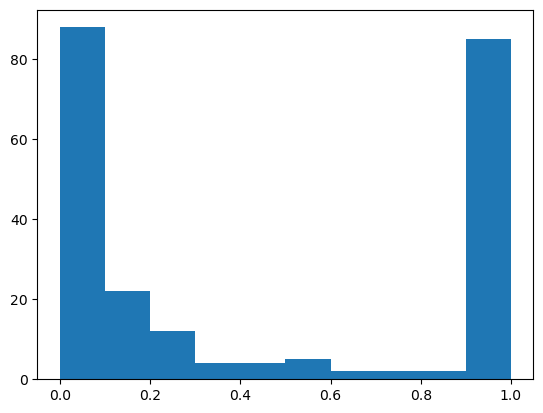

In [209]:
import matplotlib.pyplot as plt
plt.hist(b_df)